In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nibabel as nib
import json

import torch
import torch.nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from copy import deepcopy

from unet import *

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def min_max_normalize(image, min_val, max_val):
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

#예측을 위한 함수 정의
def denoise_image(model, image, slice_num):
    # 이미지 불러오기
    image = image[:, :, slice_num]

    min_val = image.min()
    max_val = image.max()
    
    # normalize
    image = min_max_normalize(image, min_val, max_val)

    image_tensor = transforms.ToTensor()(image).unsqueeze(0).type(torch.float32)

    # 모델에 이미지 전달
    with torch.no_grad():
        model.eval()
        denoised_image = model(image_tensor)

    # denormalize
    denoised_image = denoised_image*max_val
    # denoised_image = torch.clamp(denoised_image, min=0, max=max_val)

    # denormalize(denoised_image, min_val, max_val)
    
    return denoised_image.squeeze().cpu().numpy()


In [4]:
path = "C:/Users/user/Desktop/인턴/train"
os.makedirs("C:/Users/user/dicom/model/model_6/output", exist_ok = True)
save_path = "C:/Users/user/dicom/model/model_6/output"
model = UNet_model(1, 1, False)  
model.load_state_dict(torch.load("C:/Users/user/dicom/model/model_6/weights_log/final_model.pth")) 

image_list = os.listdir(path)

for i in range(35):
    # denoise_image 함수를 사용하여 denoised 이미지 생성
    image_slices = []
    image_path = os.path.join(path, image_list[i])
    
    nifti = nib.load(image_path)
    image = nifti.get_fdata()
    affine_matrix = nifti.affine

    for j in range(32):
        denoised_image = denoise_image(model, image, j)
        image_slices.append(denoised_image)
    
    volume_data = np.stack(image_slices, axis = 2)
    output = nib.Nifti1Image(volume_data, affine_matrix) # affine matrix 지정하면 kernel 종료
    nib.save(output, os.path.join(save_path, f"output_{image_list[i]}"))


## test

In [53]:
def generate_patch(image, patch_size): # 랜덤하게 patch 생성
    
    # 이미지 크기
    height, width = image.shape[2], image.shape[3]
    
    # 무작위한 패치의 시작점 결정
    top_left_x = np.random.randint(0, width - patch_size + 1)
    top_left_y = np.random.randint(0, height - patch_size + 1)

    # 이미지에서 무작위 패치 추출
    random_patch = image[:, :, top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size]

    return random_patch

def generate_subpatch(patch, patch_size): # 랜덤하게 subpatch 생성
    
    # 이미지 크기
    height, width = patch.shape[2], patch.shape[3]
    
    # 무작위한 패치의 시작점 결정
    top_left_x = np.random.randint(0, width - patch_size + 1)
    top_left_y = np.random.randint(0, height - patch_size + 1)

    # 이미지에서 무작위 패치 추출
    random_subpatch = patch[:, :, top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size]

    return [random_subpatch, top_left_x, top_left_y]

def calculate_coordinate(patch, field_size, num_subpatches): # 패치 내에서 랜덤하게 receptive field 생성
    # 64x64 크기의 패치에서 5x5 크기의 receptive field 추출
    coordinate = []
    replaced_value = []

    for i in range(num_subpatches):
        subpatch = generate_subpatch(patch, field_size)
        random_subpatch, top_row, top_col = subpatch[0], subpatch[1], subpatch[2]

        # center pixel 좌표
        center_row = top_row + (field_size // 2)
        center_col = top_col + (field_size // 2)
        center_pixel_value = patch[:, :, center_row, center_col]

        replaced_x, replaced_y = 2, 2
        # receptive field 내의 랜덤한 pixel 추출해서 대체
        while (replaced_x == 2):
            replaced_x = np.random.choice(5, replace=False)
        while (replaced_y == 2):
            replaced_y = np.random.choice(5, replace=False)

        replaced_value.append(patch[:, :, top_row + replaced_x, top_col + replaced_y])
        coordinate.append([center_row, center_col, center_pixel_value])
    
    for i in range(len(coordinate)):
        row, col, replaced = coordinate[i][0], coordinate[i][1], replaced_value[i]
        patch[:, :, row, col] = replaced
        
    return patch, coordinate

In [113]:
image = nib.load("C:/Users/user/Desktop/인턴/train/I001.nii.gz").get_fdata()
image = torch.from_numpy(image[:, :, 16])
image = torch.unsqueeze(image, dim = 0)
image = torch.unsqueeze(image, dim = 0)
min_val = image.min()
max_val = image.max()

image = min_max_normalize(image, min_val, max_val)

In [114]:
patch = generate_patch(image, 64)
random_patch = deepcopy(patch)
subpatch, coordinate = calculate_coordinate(random_patch, 5, 1000)

Text(0.5, 1.0, 'Subpatch')

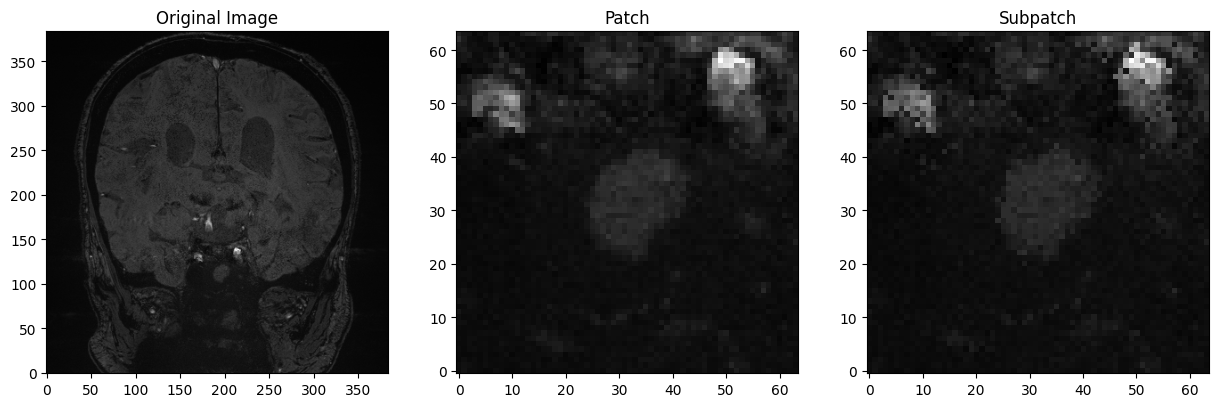

In [115]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(torch.squeeze(image).T, cmap='gray', origin = 'lower')
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(torch.squeeze(patch).T, cmap='gray', origin = 'lower')
plt.title('Patch')
plt.subplot(1, 3, 3)
plt.imshow(torch.squeeze(subpatch).T, cmap='gray', origin = 'lower')
plt.title('Subpatch')

In [116]:
model = UNet_model(1, 1, False)
outputs = model(subpatch.type(torch.float32))

In [117]:
def add_maskmap(outputs, coordinate):
    batch = outputs.shape[0]

    maskmap = torch.zeros([batch, 1, 64, 64], dtype=torch.float32)
    targets = torch.zeros([batch, 1, 64, 64], dtype=torch.float32)

    for i in range(len(coordinate)):
        row, col, value = coordinate[i][0], coordinate[i][1], coordinate[i][2] # original center pixel value
        maskmap[:, :, row, col] = 1
        targets[:, :, row, col] = value
    
    
    maskmap = maskmap.to('cuda')
    targets = targets.to('cuda')
    
    outputs = outputs * maskmap

    return outputs, targets

In [118]:
batch = outputs.shape[0]

maskmap = torch.zeros([batch, 1, 64, 64], dtype=torch.float32)
targets = torch.zeros([batch, 1, 64, 64], dtype=torch.float32)

for i in range(len(coordinate)):
        row, col, value = coordinate[i][0], coordinate[i][1], coordinate[i][2] # original center pixel value
        maskmap[:, :, row, col] = 1
        targets[:, :, row, col] = value

Text(0.5, 1.0, 'maskmap')

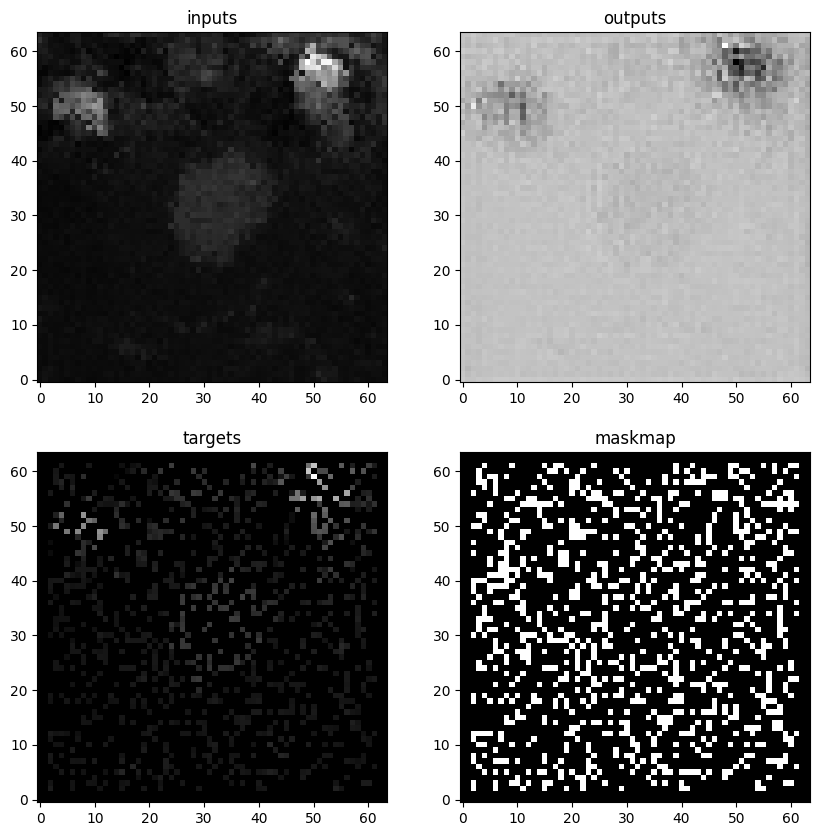

In [119]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(torch.squeeze(subpatch).T, cmap='gray', origin = 'lower')
plt.title('inputs')
plt.subplot(2, 2, 2)
plt.imshow(torch.squeeze(outputs.detach()).T, cmap='gray', origin = 'lower')
plt.title('outputs')
plt.subplot(2, 2, 3)
plt.imshow(torch.squeeze(targets).T, cmap='gray', origin = 'lower')
plt.title('targets')
plt.subplot(2, 2, 4)
plt.imshow(torch.squeeze(maskmap).T, cmap='gray', origin = 'lower')
plt.title('maskmap')

In [147]:
outputs = outputs * maskmap



tensor([0.0000, 0.0269, 0.0387, 0.0420, 0.0443, 0.0449, 0.0476, 0.0482, 0.0509,
        0.0515, 0.0531, 0.0548, 0.0551, 0.0554, 0.0558, 0.0561, 0.0568, 0.0571,
        0.0574, 0.0581, 0.0587, 0.0604, 0.0614, 0.0617, 0.0620, 0.0623, 0.0627,
        0.0630, 0.0633, 0.0636, 0.0640, 0.0643, 0.0646, 0.0650, 0.0653, 0.0656,
        0.0659, 0.0663, 0.0666, 0.0669, 0.0673, 0.0676, 0.0679, 0.0682, 0.0686,
        0.0689, 0.0692, 0.0696, 0.0699, 0.0702, 0.0705, 0.0709, 0.0712, 0.0715,
        0.0719, 0.0722, 0.0725, 0.0728, 0.0732, 0.0735, 0.0738, 0.0741, 0.0745,
        0.0748, 0.0751, 0.0755, 0.0758, 0.0761, 0.0764, 0.0768, 0.0771, 0.0774,
        0.0778, 0.0781, 0.0784, 0.0787, 0.0791, 0.0794, 0.0797, 0.0801, 0.0804,
        0.0807, 0.0810, 0.0814, 0.0817, 0.0820, 0.0823, 0.0827, 0.0830, 0.0833,
        0.0837, 0.0840, 0.0843, 0.0846, 0.0850, 0.0853, 0.0856, 0.0860, 0.0863,
        0.0866, 0.0869, 0.0873, 0.0876, 0.0879, 0.0883, 0.0886, 0.0889, 0.0892,
        0.0896, 0.0899, 0.0902, 0.0906, 

Text(0.5, 1.0, 'targets')

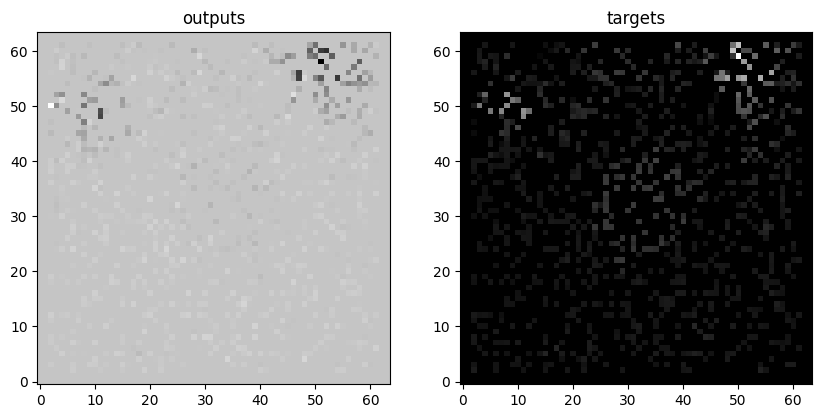

In [121]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(torch.squeeze(outputs.detach()).T, cmap='gray', origin = 'lower')
plt.title('outputs')
plt.subplot(1, 2, 2)
plt.imshow(torch.squeeze(targets).T, cmap='gray', origin = 'lower')
plt.title('targets')

# loss graph

In [18]:
log = pd.read_csv("C:/Users/user/dicom/model/model_3/model_log/train_log.csv")

In [7]:
log.columns = ['model', 'loss']

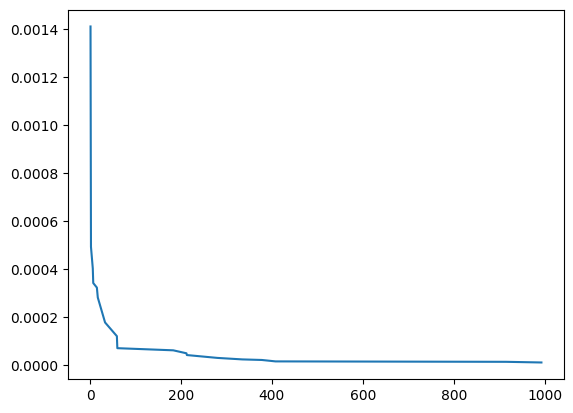

In [9]:
x = log['model']
y = log['loss']

plt.plot(x, y)
plt.show()